# PHYS 581 - Assignment 4
## Siegfried Peschke - 30032136
### March 8, 2021

In this assignment we explore the parallelization of generating a neural network which will determine the slope and intercept from sets of data representing 2-D lines. The Keras package auto-parallelizes but also offers some features which allow one to determine the thread count, so this will be used as a benchmark in comparing to the ipyparallel package which will be used for manual parallelization.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

In [2]:
def gen_dataset_straightline(ncases=1000, domain=(-3,3), datapoints=5, paramlim=[(0,1),(0,1)]):
    """
    This function generates straight lines with slopes and intercepts within a specified range
    corresponding to a specified set of datapoints within a specified domain.
    """
    x = np.random.random( (ncases, datapoints) )*2*domain[1] + domain[0]
    nx = datapoints
    
    y = np.zeros( (ncases, nx) ) 
    
    params = np.random.random( (ncases,2) )
    for pindx in [0,1]:
        p = paramlim[pindx]
        p0 = p[0]
        dp = p[1] - p[0]
        params[:,pindx] = params[:,pindx]*dp + p0

    for indx in range(ncases):
        y[indx,0:nx] = x[indx,:]*params[indx,0] + params[indx,1]
    
    return y, x, params

def gen_ideal_dataset_straightline(ncases=1000, x=(-2, -1, 0, +1, +2), paramlim=[(0,1),(0,1)]):
    """ 
    This function generates straight lines with slopes and intercepts within a specified range
    corresponding to datapoints f(-2), f(-1), f(0), f(1) and f(2).
    """
    x = np.array(x, dtype=np.float64)
    nx = len(x) ;# [-2, -1, 0, +1, +2]
    x = np.ones(ncases).reshape(ncases,1) * x.reshape(1,nx)
    
    y = np.zeros( (ncases, nx) ) 
    
    params = np.random.random( (ncases,2) )  # uniform from 0 to 1
    for pindx in [0,1]:
        p = paramlim[pindx]
        p0 = p[0]
        dp = p[1] - p[0]
        params[:,pindx] = params[:,pindx]*dp + p0

    for indx in range(ncases):
        y[indx,0:nx] = x[indx,:]*params[indx,0] + params[indx,1]
    
    return y, x, params 

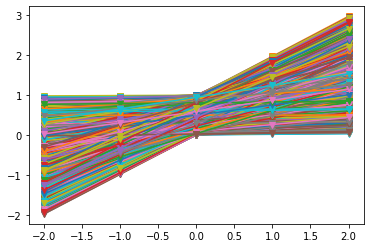

In [3]:
datay, datax, params = gen_ideal_dataset_straightline(ncases = 5000)
plt.plot( datax.T, datay.T, 'v-' );

In [4]:
def gen_model(indata, outdata, layers = 4):
    """
    This function generates the general topology for a Keras model.
    """
    import tensorflow
    from tensorflow import keras
    from keras.models import Sequential
    from keras.layers import Dense
    
    ncases, nsteps = indata.shape
    inputs = keras.Input( shape=( nsteps, ), name='input' )    
    xx = keras.layers.Dense(nsteps, input_dim=nsteps, activation='relu', name='dense1') (inputs)
    for i in range(2, layers+1):
        xx = keras.layers.Dense(nsteps, input_dim=nsteps, activation='relu', name='dense'+str(i)) (xx)
    outputs = keras.layers.Dense(2, activation=None, name='output_slope_intercept')(xx)
    model = keras.Model( inputs=inputs, outputs=outputs, name='Main' )
    model.compile( optimizer='rmsprop', loss='mean_squared_error' )
    return model

In [5]:
model = gen_model(datay, params)
print(model.summary())

Model: "Main"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 5)]               0         
_________________________________________________________________
dense1 (Dense)               (None, 5)                 30        
_________________________________________________________________
dense2 (Dense)               (None, 5)                 30        
_________________________________________________________________
dense3 (Dense)               (None, 5)                 30        
_________________________________________________________________
dense4 (Dense)               (None, 5)                 30        
_________________________________________________________________
output_slope_intercept (Dens (None, 2)                 12        
Total params: 132
Trainable params: 132
Non-trainable params: 0
________________________________________________________________

In [6]:
def train_model(indata, outdata, batch_size = 64, epochs = 50, delay=0.0):
    """
    This function utilizes gen_model in order to create and train a model for some data.
    Designed for use in parallelization, keeping track of the model generation and training times.
    """
    import time
    
    if delay is not None: time.sleep(delay)
    t0 = time.perf_counter()
    model = gen_model(indata, outdata)
    t1 = time.perf_counter()
    result = model.fit( indata, outdata, batch_size=batch_size, epochs=epochs, verbose=0, validation_split=0.3 )
    t2 = time.perf_counter()
    times = [t2-t0, t2-t1, t1-t0]
    return result.history, times

In [7]:
datay, datax, params = gen_ideal_dataset_straightline(ncases = 10000)
results, times = train_model(datay, params)
print(times)

[3.4357391, 3.4118721, 0.023867000000000083]


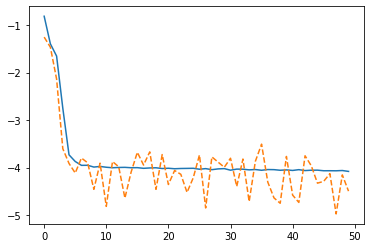

In [8]:
plt.plot( np.log10(results['loss']) )
plt.plot( np.log10(results['val_loss']), '--' )

Now that we have the necessary functions to generate our datasets and create and train a model easily, let us explore how changing the amount of threads through Keras influences computation times.

In [9]:
def set_tf_threads(n):
    """ 
    Try to set the number of threads used by tensorflow.
    
    Note: this part of the API seems to change a lot,
    and currently generates a lot of warnings:
    
    Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x000002902977A048>
    Traceback (most recent call last):
    File "anaconda3\envs\phys581\lib\site-packages\tensorflow\python\eager\function.py", line 386, in __del__
    context.remove_function(self.name)
    """
    import tensorflow
    from tensorflow.python.eager import context

    context._context = None
    context._create_context()

    tensorflow.config.threading.set_intra_op_parallelism_threads(
        num_threads = n
    )

    tensorflow.config.threading.set_inter_op_parallelism_threads(
        num_threads = n
    )

In [10]:
results_col = []
times_col = []

for threadnum in [1,2,3,4,5,6]:
    set_tf_threads(threadnum)
    results, times = train_model(datay, params)
    results_col.append(results)
    times_col.append(times)

Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x0000011F387A3AF0>
Traceback (most recent call last):
  File "C:\Users\Sigi\anaconda3\envs\phys581\lib\site-packages\tensorflow\python\eager\function.py", line 386, in __del__
    context.remove_function(self.name)
  File "C:\Users\Sigi\anaconda3\envs\phys581\lib\site-packages\tensorflow\python\eager\context.py", line 2353, in remove_function
    context().remove_function(name)
  File "C:\Users\Sigi\anaconda3\envs\phys581\lib\site-packages\tensorflow\python\eager\context.py", line 1163, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Tried to remove non-existent function '__inference_Dataset_map_permutation_10559'.
Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x0000011F387A3AF0>
Traceback (most recent call last):
  File "C:\Users\Sigi\anaconda3\envs\phys581\lib\site-packages\tensorflow\python\ea

Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x0000011F387A3AF0>
Traceback (most recent call last):
  File "C:\Users\Sigi\anaconda3\envs\phys581\lib\site-packages\tensorflow\python\eager\function.py", line 386, in __del__
    context.remove_function(self.name)
  File "C:\Users\Sigi\anaconda3\envs\phys581\lib\site-packages\tensorflow\python\eager\context.py", line 2353, in remove_function
    context().remove_function(name)
  File "C:\Users\Sigi\anaconda3\envs\phys581\lib\site-packages\tensorflow\python\eager\context.py", line 1163, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Tried to remove non-existent function '__inference_test_function_1360'.
Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x0000011F387A3AF0>
Traceback (most recent call last):
  File "C:\Users\Sigi\anaconda3\envs\phys581\lib\site-packages\tensorflow\python\eager\functio

Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x0000011F387A3AF0>
Traceback (most recent call last):
  File "C:\Users\Sigi\anaconda3\envs\phys581\lib\site-packages\tensorflow\python\eager\function.py", line 386, in __del__
    context.remove_function(self.name)
  File "C:\Users\Sigi\anaconda3\envs\phys581\lib\site-packages\tensorflow\python\eager\context.py", line 2353, in remove_function
    context().remove_function(name)
  File "C:\Users\Sigi\anaconda3\envs\phys581\lib\site-packages\tensorflow\python\eager\context.py", line 1163, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Tried to remove non-existent function '__inference_train_function_19748'.
Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x0000011F387A3AF0>
Traceback (most recent call last):
  File "C:\Users\Sigi\anaconda3\envs\phys581\lib\site-packages\tensorflow\python\eager\funct

Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x0000011F387A3AF0>
Traceback (most recent call last):
  File "C:\Users\Sigi\anaconda3\envs\phys581\lib\site-packages\tensorflow\python\eager\function.py", line 386, in __del__
    context.remove_function(self.name)
  File "C:\Users\Sigi\anaconda3\envs\phys581\lib\site-packages\tensorflow\python\eager\context.py", line 2353, in remove_function
    context().remove_function(name)
  File "C:\Users\Sigi\anaconda3\envs\phys581\lib\site-packages\tensorflow\python\eager\context.py", line 1163, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Tried to remove non-existent function '__inference_Dataset_flat_map_slice_batch_indices_29211'.
Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x0000011F387A3AF0>
Traceback (most recent call last):
  File "C:\Users\Sigi\anaconda3\envs\phys581\lib\site-packages\tensorf

Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x0000011F387A3AF0>
Traceback (most recent call last):
  File "C:\Users\Sigi\anaconda3\envs\phys581\lib\site-packages\tensorflow\python\eager\function.py", line 386, in __del__
    context.remove_function(self.name)
  File "C:\Users\Sigi\anaconda3\envs\phys581\lib\site-packages\tensorflow\python\eager\context.py", line 2353, in remove_function
    context().remove_function(name)
  File "C:\Users\Sigi\anaconda3\envs\phys581\lib\site-packages\tensorflow\python\eager\context.py", line 1163, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Tried to remove non-existent function '__inference_Dataset_map_grab_batch_38544'.


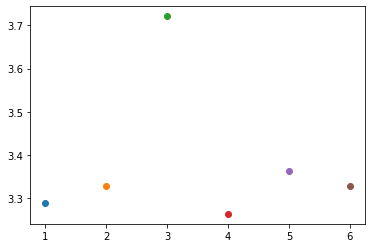

In [11]:
for x, times in enumerate(times_col, start=1):
    plt.scatter(x, times[0])

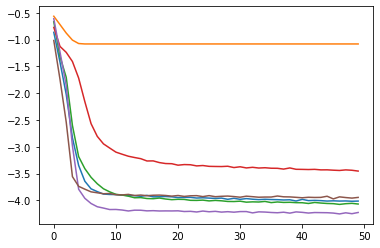

In [12]:
for results in results_col:
    plt.plot( np.log10(results['loss']) )

From the first plot above, we can clearly see that varying the thread count through Keras did not have any obvious effect on computation speeds. This may indicate the way we set up the problem may not lend itself to parallelization so easily.

Let us move on to exploring ipyparallel.

In [13]:
import ipyparallel as ipp
#ipcluster start -n 6
client = ipp.Client()
client.ids

[0, 1, 2, 3, 4, 5]

Since varying parallelization through Keras did not seem to yield any results, instead of passing one model and parallelizing the computation, we will take copies of a model and assign each thread to handle its own model. This may be useful since each thread will return a different model and of these we may select the best one.

In [14]:
set_tf_threads(1)
datay, datax, params = gen_ideal_dataset_straightline(ncases = 10000)
time0 = []
info = []
for core in client:
    time0.append( time.perf_counter() )    
    core.push( dict(gen_model=gen_model) )
    info.append( core.apply_sync( train_model, datay, params ) )
    time0.append( time.perf_counter() )    
    print(np.array(time0[1::2]) - np.array(time0[0::2])  )
          
time0 = np.array(time0)        
print(time0[1::2] - time0[0::2], '\n', time0[-1]-time0[0])

[3.3418915]
[3.3418915 3.2240477]
[3.3418915 3.2240477 3.3761436]
[3.3418915 3.2240477 3.3761436 3.3318306]
[3.3418915 3.2240477 3.3761436 3.3318306 3.4846632]
[3.3418915 3.2240477 3.3761436 3.3318306 3.4846632 3.4047099]
[3.3418915 3.2240477 3.3761436 3.3318306 3.4846632 3.4047099] 
 20.166218900000004


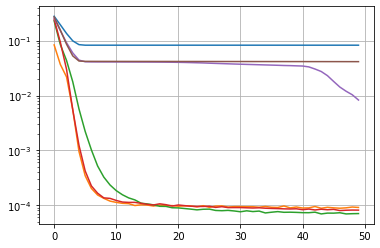

In [15]:
for i in info:
    history, times = i
    plt.plot( history['loss'] )
plt.yscale('log')
plt.grid(True)

Using the synchronous (`apply_sync`) setting sets ipyparallel to blocking assignment of jobs. This means that jobs are executed in series where the current assignment blocks execution of the next assignment until it is finished. This is useful in the case that an assignment depends on information from the previous assignment.

However, in this situation we are sending models to be independently computed at the client level. Thus it is more useful in our case to allow jobs to run simultaneously. Changing to the asychronous (`apply_async`) setting allows us to switch to non-blocking assignment of jobs.

In [16]:
set_tf_threads(1)
datay, datax, params = gen_ideal_dataset_straightline(ncases = 10000)
time0 = []
info = []
for core in client:
    time0.append( time.perf_counter() )    
    core.push( dict(gen_model=gen_model) )
    info.append( core.apply_async( train_model, datay, params ) )
    time0.append( time.perf_counter() )    
    print(np.array(time0[1::2]) - np.array(time0[0::2])  )
          
time0 = np.array(time0)        
print(time0[1::2] - time0[0::2], '\n', time0[-1]-time0[0])

[0.0010809]
[0.0010809 0.0008168]
[0.0010809 0.0008168 0.0010629]
[0.0010809 0.0008168 0.0010629 0.0008162]
[0.0010809 0.0008168 0.0010629 0.0008162 0.0007274]
[0.0010809 0.0008168 0.0010629 0.0008162 0.0007274 0.0009433]
[0.0010809 0.0008168 0.0010629 0.0008162 0.0007274 0.0009433] 
 0.008873899999997548


{'msg_id': None,
 'submitted': datetime.datetime(2021, 3, 15, 1, 52, 14, 303359, tzinfo=tzutc()),
 'started': None,
 'completed': None,
 'received': None,
 'engine_uuid': None,
 'engine_id': None,
 'follow': None,
 'after': None,
 'status': None,
 'execute_input': None,
 'execute_result': None,
 'error': None,
 'stdout': '',
 'stderr': '',
 'outputs': [],
 'data': {}}

In [23]:
info[-1].metadata

{'msg_id': 'c17ecd6e-55fdd4d1f3e1573a16da0c46_24',
 'submitted': datetime.datetime(2021, 3, 15, 1, 52, 14, 311366, tzinfo=tzutc()),
 'started': datetime.datetime(2021, 3, 15, 1, 52, 14, 323379, tzinfo=tzutc()),
 'completed': datetime.datetime(2021, 3, 15, 1, 52, 19, 385986, tzinfo=tzutc()),
 'received': datetime.datetime(2021, 3, 15, 1, 52, 19, 387986, tzinfo=tzutc()),
 'engine_uuid': 'efd37a23-7051af4c3d8e5a2a7c5be899',
 'engine_id': 5,
 'follow': [],
 'after': [],
 'status': 'ok',
 'execute_input': None,
 'execute_result': None,
 'error': None,
 'stdout': '',
 'stderr': '',
 'outputs': [],
 'data': {}}

In [20]:
[i.metadata['completed'] - i.metadata['started'] for i in info]

[datetime.timedelta(seconds=5, microseconds=9560),
 datetime.timedelta(seconds=4, microseconds=624209),
 datetime.timedelta(seconds=4, microseconds=967521),
 datetime.timedelta(seconds=4, microseconds=787357),
 datetime.timedelta(seconds=5, microseconds=76619),
 datetime.timedelta(seconds=5, microseconds=62607)]

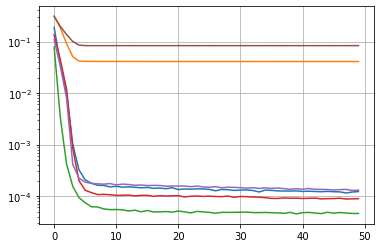

In [22]:
for i in info:
    history, times = i.get() 
    plt.plot( history['loss'] )
plt.yscale('log')
plt.grid(True)

Through non-blocking parallelization of our task, we achieve the ability to train multiple models at the same time. From the results we then could select the best model, which in the case of the above plot is the one which achieves the lowest amount of loss.

The main purpose of this assignment was to determine if paralellization of training a model would yield faster training times. But it does not seem possible as shown by varying the threads utilized by Keras. Instead, a compensation we achieve is learning that we may train models asynchronously utilizing ipyparallel which allows for increased speed in training multiple models.